In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(12,9)})

from wrangle_zillow import wrangle_zillow, scaled_zillow_columns
from explore import elbow_plot, run_kmeans, add_to_train

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
train, validate, test = wrangle_zillow()

In [3]:
X_train = train.drop(columns=['error'])
y_train = train[['error']]

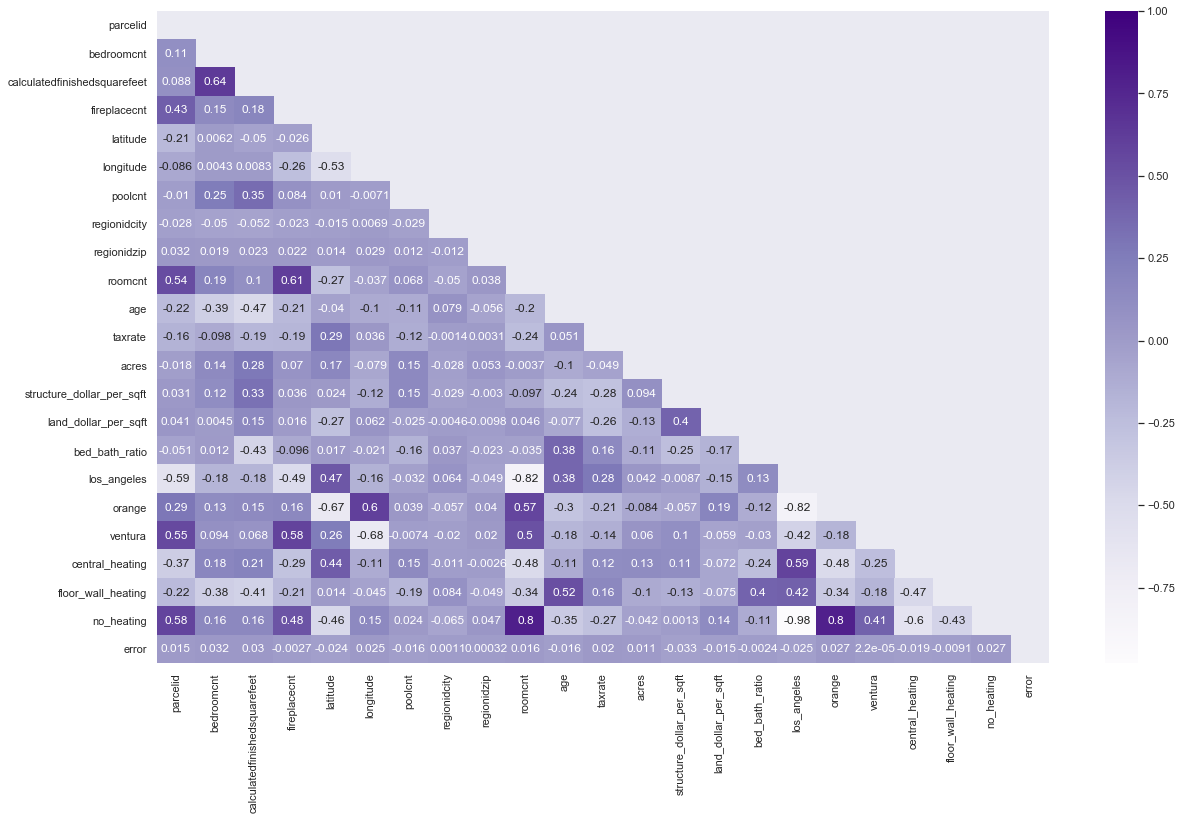

In [4]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,12))
sns.heatmap(train.corr(), cmap='Purples', annot=True, mask=mask)
plt.show()

In [5]:
import math
abs(train.corr().error).sort_values(ascending = False)

error                           1.000000
structure_dollar_per_sqft       0.032991
bedroomcnt                      0.031790
calculatedfinishedsquarefeet    0.030269
orange                          0.027129
no_heating                      0.027107
longitude                       0.025376
los_angeles                     0.025052
latitude                        0.023663
taxrate                         0.020288
central_heating                 0.018522
poolcnt                         0.015922
roomcnt                         0.015894
age                             0.015559
parcelid                        0.015402
land_dollar_per_sqft            0.014654
acres                           0.010879
floor_wall_heating              0.009072
fireplacecnt                    0.002726
bed_bath_ratio                  0.002376
regionidcity                    0.001073
regionidzip                     0.000318
ventura                         0.000022
Name: error, dtype: float64

Conclusion: 
- structure dollar per sqft has the highest correlation overall to logerror
- Orange and LA county are in the top 7 with having the highest correlation to logerror
- longitude and latitude are also in the top ten but that makes sense given that Orange and LA are listed higher
- 

There is a difference in errors but it is significant?

In [6]:
la_error = train[train.los_angeles == 1].error
orange_error = train[train.orange == 1].error
ventura_error = train[train.ventura == 1].error

Equal Variance?

In [7]:
from scipy import stats

stats.levene(la_error, orange_error, ventura_error)

LeveneResult(statistic=18.929427065016203, pvalue=6.0899900130145475e-09)

In [8]:
alpha = .05

In [9]:
from scipy.stats import f_oneway

In [10]:
f, p = f_oneway(la_error, orange_error, ventura_error)
p

2.3769601834158e-05

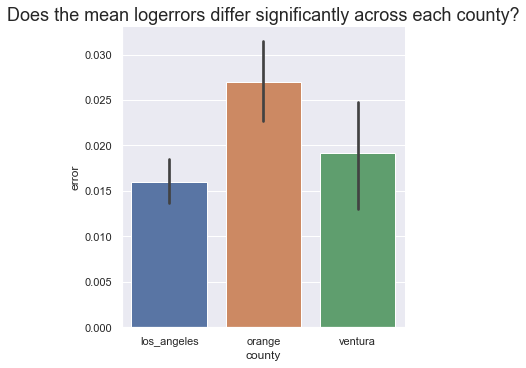

In [11]:
sns.catplot(x="county", y="error", kind="bar", data=train)
plt.title("Does the mean logerrors differ significantly across each county?", size = 18)
plt.show()

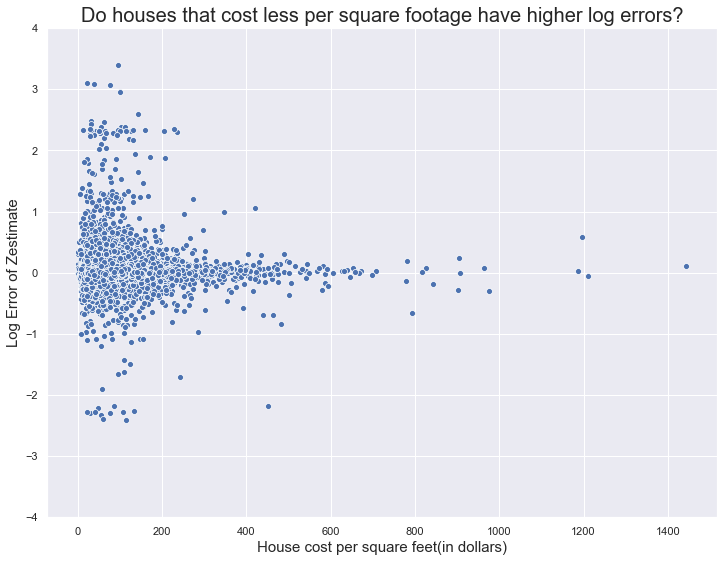

In [12]:
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'error', data = train)
plt.title("Do houses that cost less per square footage have higher log errors?", size = 20)
plt.xlabel("House cost per square feet(in dollars)", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.ylim(-4, 4)
plt.show()

Is there a significance?

In [13]:
null_hypothesis = "Log errors in low cost per sqft are the same as the log errors for the rest of the houses"
alternative_hypothesis = "Log errors in low cost per sqft are different than the log errors for the rest of the houses" 

In [14]:
low_cost_sqft = train[train.structure_dollar_per_sqft < 200]
t, p = stats.ttest_1samp(low_cost_sqft.error, train.error.mean())
t, p

(0.3241526634826526, 0.7458249674639328)

Is there a significant difference in logerrors between bedrooms?

In [15]:
one_bed = train[train.bedroomcnt == 1].error
two_bed = train[train.bedroomcnt == 2].error
three_bed = train[train.bedroomcnt == 3].error
four_bed = train[train.bedroomcnt == 5].error
five_bed = train[train.bedroomcnt == 4].error
six_bed = train[train.bedroomcnt == 6].error
seven_bed = train[train.bedroomcnt == 7].error

In [16]:
f, p = f_oneway(one_bed, two_bed, three_bed, four_bed, five_bed, six_bed, seven_bed)
p

1.2878894227156024e-06

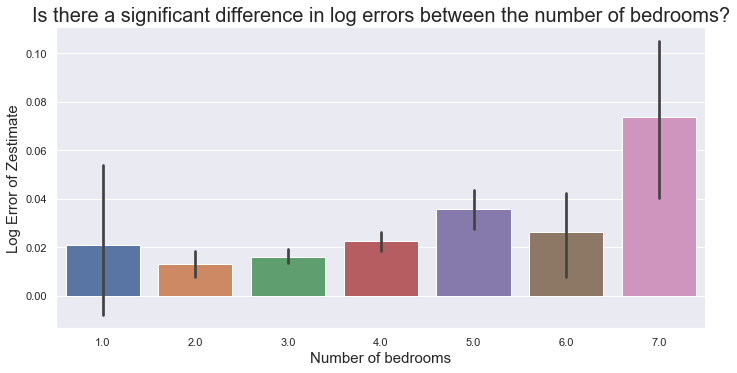

In [17]:
sns.catplot(x="bedroomcnt", y="error", kind="bar", data=train, height=5, aspect=2)
plt.title("Is there a significant difference in log errors between the number of bedrooms?", size = 20)
plt.xlabel("Number of bedrooms", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

In [18]:
train_scaled, validate_scaled, test_scaled = scaled_zillow_columns()

In [20]:
X_train_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_train_scaled = train_scaled[['error']]
X_validate_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_validate_scaled = train_scaled[['error']]
X_test_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_test_scaled = train_scaled[['error']]

In [21]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   heatingorsystemdesc                  27955 non-null  object 
 1   county                               27955 non-null  object 
 2   los_angeles                          27955 non-null  uint8  
 3   orange                               27955 non-null  uint8  
 4   ventura                              27955 non-null  uint8  
 5   central_heating                      27955 non-null  uint8  
 6   floor_wall_heating                   27955 non-null  uint8  
 7   no_heating                           27955 non-null  uint8  
 8   bedroomcnt_scaled                    27955 non-null  float64
 9   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 10  fireplacecnt_scaled                  27955 non-null  float64
 11  latitude_scaled         

In [22]:
size_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled']

In [23]:
value_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled']

In [24]:
feature_vars = ['fireplacecnt_scaled', 'poolcnt_scaled']

     k         sse
0    2  211.830340
1    3  123.609694
2    4   86.292286
3    5   66.542507
4    6   54.878031
5    7   43.634692
6    8   36.688734
7    9   32.014325
8   10   28.495632
9   11   25.184617
10  12   22.908766
11  13   20.917200
12  14   19.202045
13  15   17.836880
14  16   16.425231
15  17   15.319673
16  18   14.482024
17  19   13.716007


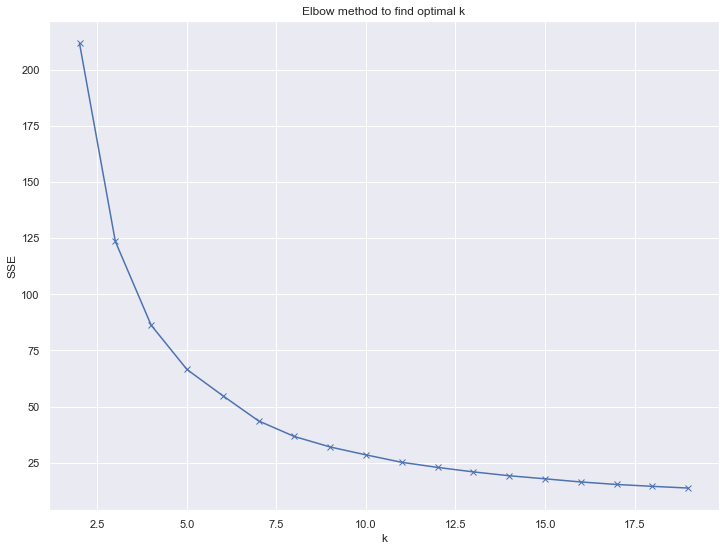

In [25]:
elbow_plot(size_vars, X_train_scaled)

In [26]:
train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled'], 
                                    cluster_col_name = 'size_cluster', X_train_scaled = X_train_scaled)

In [27]:
train_clusters.size_cluster.value_counts()

3    10451
0     9261
1     5264
4     2372
2      607
Name: size_cluster, dtype: int64

In [28]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'size_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

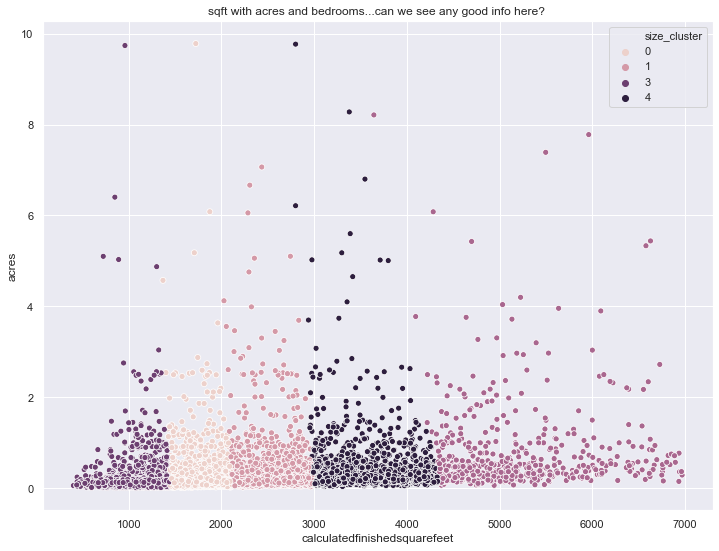

In [29]:
sns.scatterplot(x='calculatedfinishedsquarefeet', y='acres', hue='size_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()

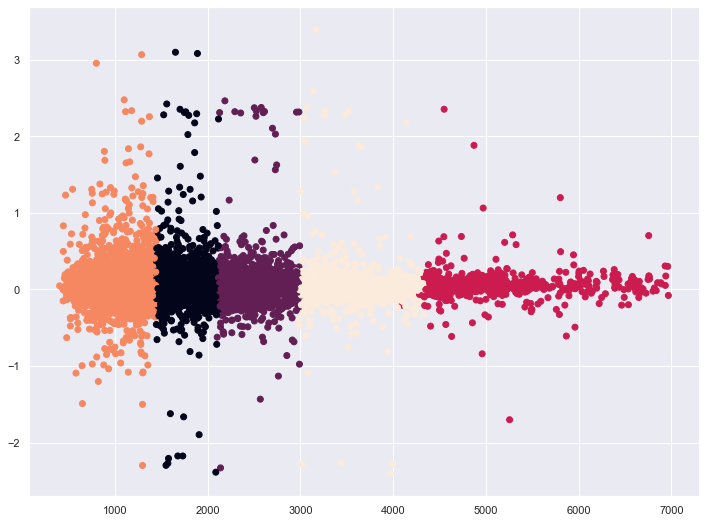

In [30]:
plt.scatter(X_train.calculatedfinishedsquarefeet, y_train.error, c=X_train.size_cluster)
plt.show()

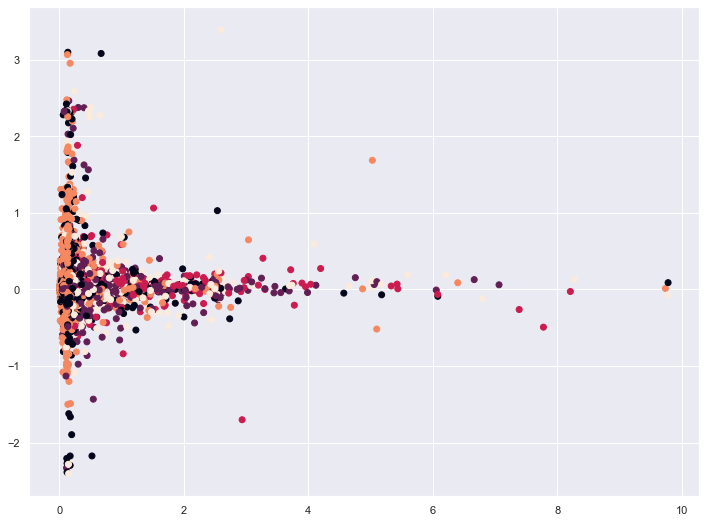

In [31]:
plt.scatter(X_train.acres, y_train.error, c=X_train.size_cluster)
plt.show()

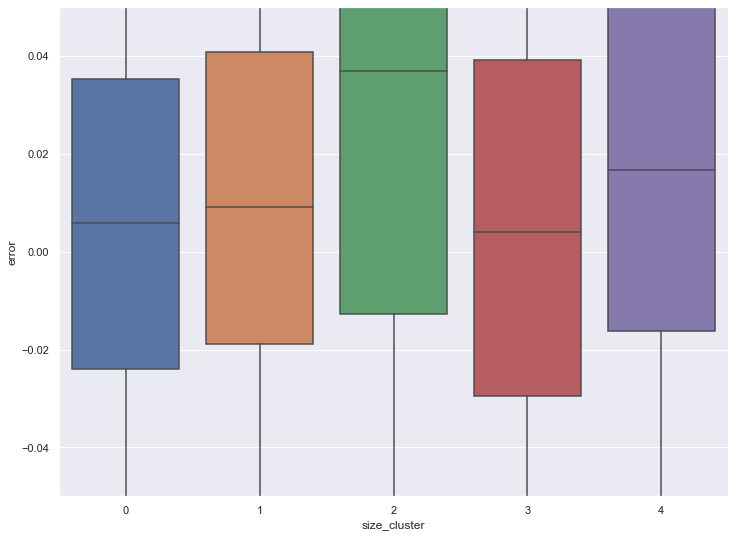

In [32]:
sns.boxplot(X_train.size_cluster, y_train.error)
plt.ylim(-.05,.05)
plt.show()

In [33]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      27955 non-null  int64  
 1   bedroomcnt                    27955 non-null  float64
 2   calculatedfinishedsquarefeet  27955 non-null  float64
 3   fireplacecnt                  27955 non-null  float64
 4   latitude                      27955 non-null  float64
 5   longitude                     27955 non-null  float64
 6   poolcnt                       27955 non-null  float64
 7   regionidcity                  27955 non-null  float64
 8   regionidzip                   27955 non-null  float64
 9   roomcnt                       27955 non-null  float64
 10  transactiondate               27955 non-null  object 
 11  heatingorsystemdesc           27955 non-null  object 
 12  age                           27955 non-null  float64
 1

In [34]:
cluster0 = train[train.size_cluster == 0].error
cluster1 = train[train.size_cluster == 1].error
cluster2 = train[train.size_cluster == 2].error
cluster3 = train[train.size_cluster == 3].error
cluster4 = train[train.size_cluster == 4].error

In [ ]:
f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4)
p

In [35]:
X_validate_scaled, X_test_scaled = add_to_train(train_clusters, cluster_col_name = 'size_cluster', X_train = X_validate_scaled, X_train_scaled = X_test_scaled)

In [36]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   heatingorsystemdesc                  27955 non-null  object 
 1   county                               27955 non-null  object 
 2   los_angeles                          27955 non-null  uint8  
 3   orange                               27955 non-null  uint8  
 4   ventura                              27955 non-null  uint8  
 5   central_heating                      27955 non-null  uint8  
 6   floor_wall_heating                   27955 non-null  uint8  
 7   no_heating                           27955 non-null  uint8  
 8   bedroomcnt_scaled                    27955 non-null  float64
 9   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 10  fireplacecnt_scaled                  27955 non-null  float64
 11  latitude_scaled         

     k           sse
0    2  3.429006e+02
1    3  1.487554e+02
2    4  5.300229e+01
3    5  2.884431e+01
4    6  8.071085e+00
5    7  3.809558e+00
6    8  6.694602e-01
7    9  1.772727e-01
8   10  1.098326e-22
9   11  1.098326e-22
10  12  1.098326e-22
11  13  1.098326e-22
12  14  1.098326e-22
13  15  1.098326e-22
14  16  1.098326e-22
15  17  1.098326e-22
16  18  1.098326e-22
17  19  1.098326e-22


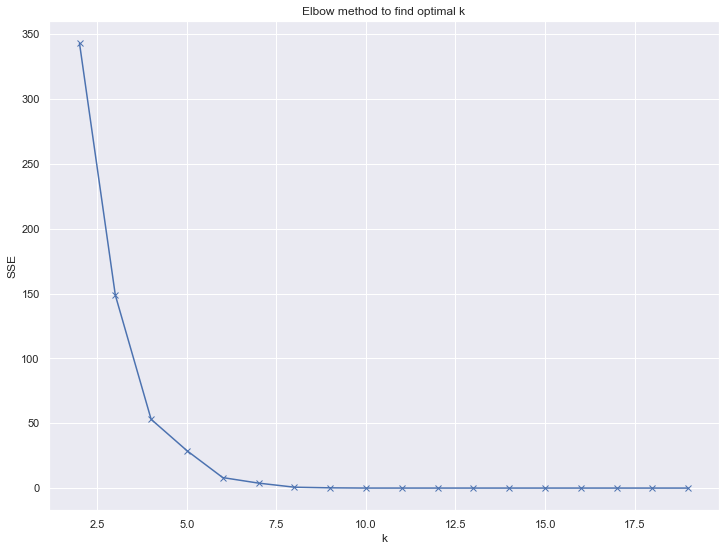

In [37]:
elbow_plot(feature_vars, X_train_scaled)

In [38]:
train_clusters, kmeans = run_kmeans(4,  cluster_vars = ['fireplacecnt_scaled', 'poolcnt_scaled'], 
                                    cluster_col_name = 'feature_cluster', X_train_scaled = X_train_scaled)

In [39]:
train_clusters.feature_cluster.value_counts()

0    19450
1     4765
2     2768
3      972
Name: feature_cluster, dtype: int64

In [40]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'feature_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

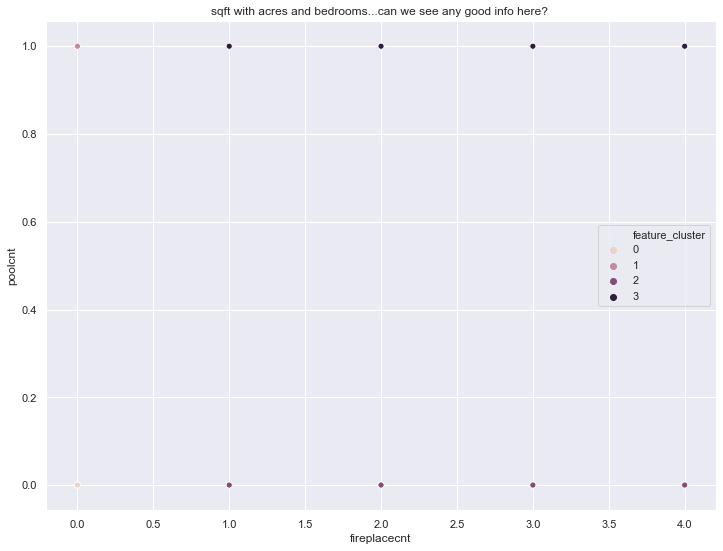

In [42]:
sns.scatterplot(x='fireplacecnt', y='poolcnt', hue='feature_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()

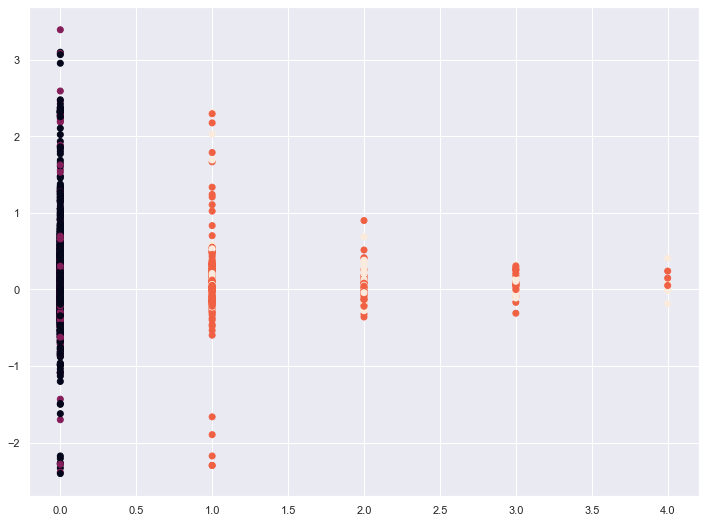

In [43]:
plt.scatter(X_train.fireplacecnt, y_train.error, c=X_train.feature_cluster)
plt.show()

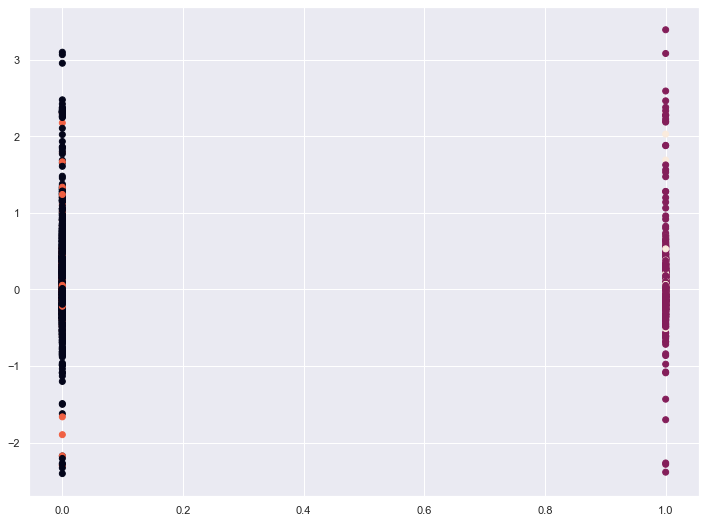

In [44]:
plt.scatter(X_train.poolcnt, y_train.error, c=X_train.feature_cluster)
plt.show()

(-0.5, 0.5)

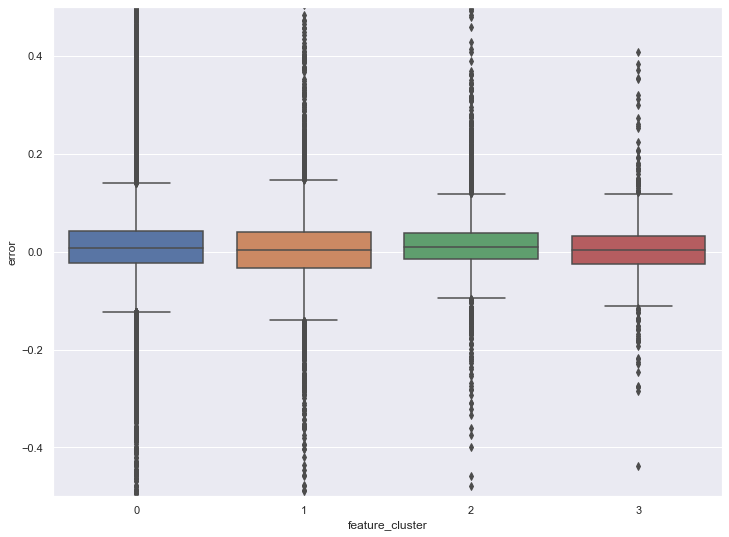

In [45]:
sns.boxplot(X_train.feature_cluster, y_train.error)
plt.ylim(-.5,.5)

In [41]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      27955 non-null  int64  
 1   bedroomcnt                    27955 non-null  float64
 2   calculatedfinishedsquarefeet  27955 non-null  float64
 3   fireplacecnt                  27955 non-null  float64
 4   latitude                      27955 non-null  float64
 5   longitude                     27955 non-null  float64
 6   poolcnt                       27955 non-null  float64
 7   regionidcity                  27955 non-null  float64
 8   regionidzip                   27955 non-null  float64
 9   roomcnt                       27955 non-null  float64
 10  transactiondate               27955 non-null  object 
 11  heatingorsystemdesc           27955 non-null  object 
 12  age                           27955 non-null  float64
 1

In [46]:
cluster0 = train[train.feature_cluster == 0].error
cluster1 = train[train.feature_cluster == 1].error
cluster2 = train[train.feature_cluster == 2].error
cluster3 = train[train.feature_cluster == 3].error

In [47]:
f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4)
p

0.0007631527117548045

In [48]:
X_validate_scaled, X_test_scaled = add_to_train(train_clusters, cluster_col_name = 'feature_cluster', X_train = X_validate_scaled, X_train_scaled = X_test_scaled)

In [49]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   heatingorsystemdesc                  27955 non-null  object 
 1   county                               27955 non-null  object 
 2   los_angeles                          27955 non-null  uint8  
 3   orange                               27955 non-null  uint8  
 4   ventura                              27955 non-null  uint8  
 5   central_heating                      27955 non-null  uint8  
 6   floor_wall_heating                   27955 non-null  uint8  
 7   no_heating                           27955 non-null  uint8  
 8   bedroomcnt_scaled                    27955 non-null  float64
 9   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 10  fireplacecnt_scaled                  27955 non-null  float64
 11  latitude_scaled         

     k        sse
0    2  57.371925
1    3  42.543433
2    4  34.613982
3    5  27.199510
4    6  22.422225
5    7  19.449716
6    8  16.718188
7    9  14.925400
8   10  13.393305
9   11  12.135708
10  12  11.153444
11  13  10.258075
12  14   9.439352
13  15   8.778457
14  16   8.180428
15  17   7.584720
16  18   7.189448
17  19   6.869642


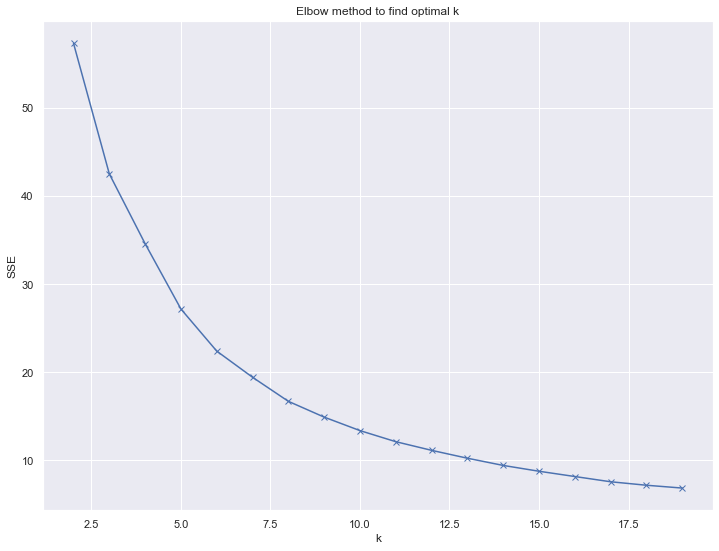

In [50]:
elbow_plot(value_vars, X_train_scaled)

In [51]:
train_clusters, kmeans = run_kmeans(6,  cluster_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled'], 
                                    cluster_col_name = 'value_cluster', X_train_scaled = X_train_scaled)

In [52]:
train_clusters.value_cluster.value_counts()

5    12692
0     9619
2     3900
1     1420
4      253
3       71
Name: value_cluster, dtype: int64

In [53]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'value_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

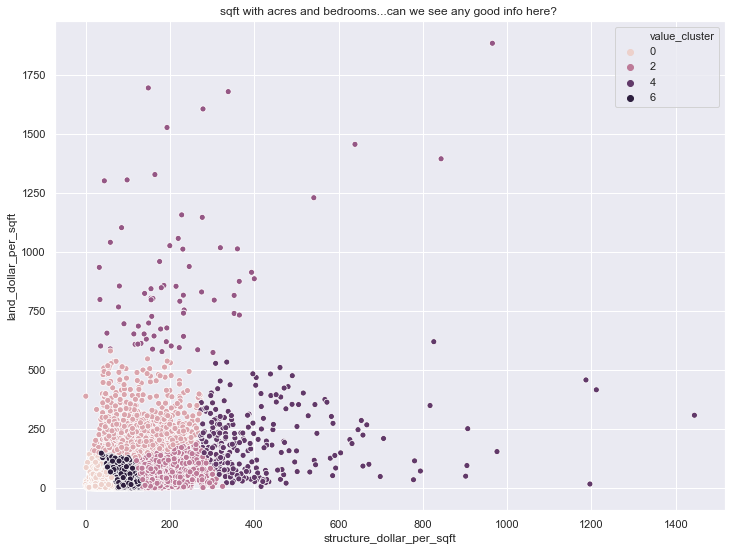

In [54]:
sns.scatterplot(x='structure_dollar_per_sqft', y='land_dollar_per_sqft', hue='value_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()

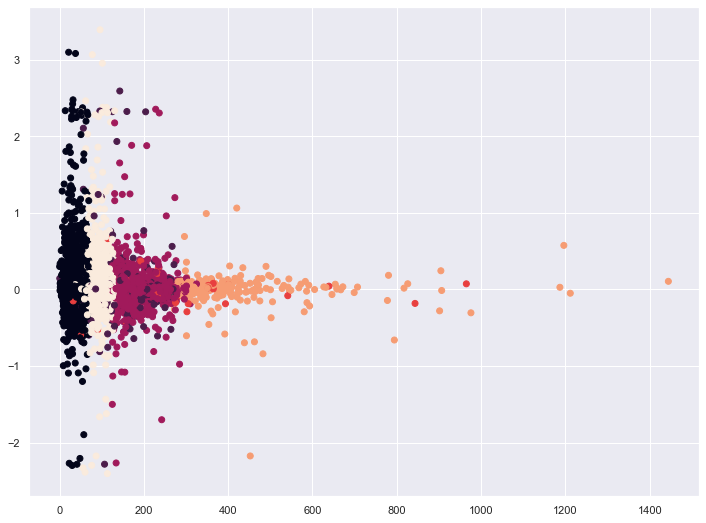

In [55]:
plt.scatter(train.structure_dollar_per_sqft, train.error, c=X_train.value_cluster)
plt.show()

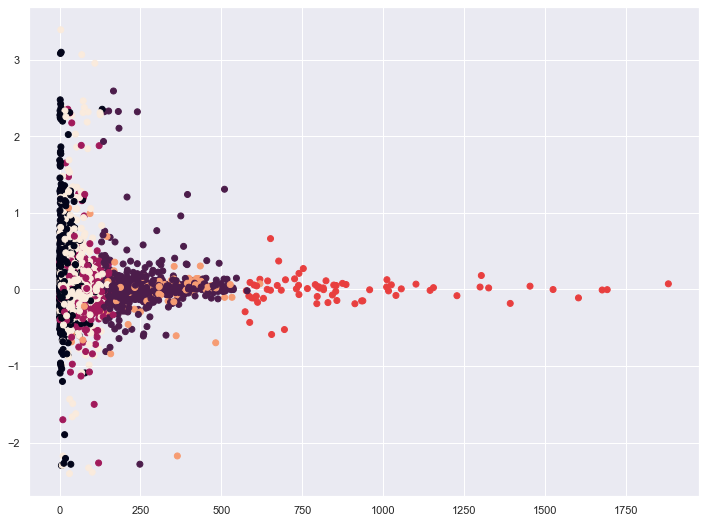

In [56]:
plt.scatter(X_train.land_dollar_per_sqft, y_train.error, c=X_train.value_cluster)
plt.show()

(-0.5, 0.5)

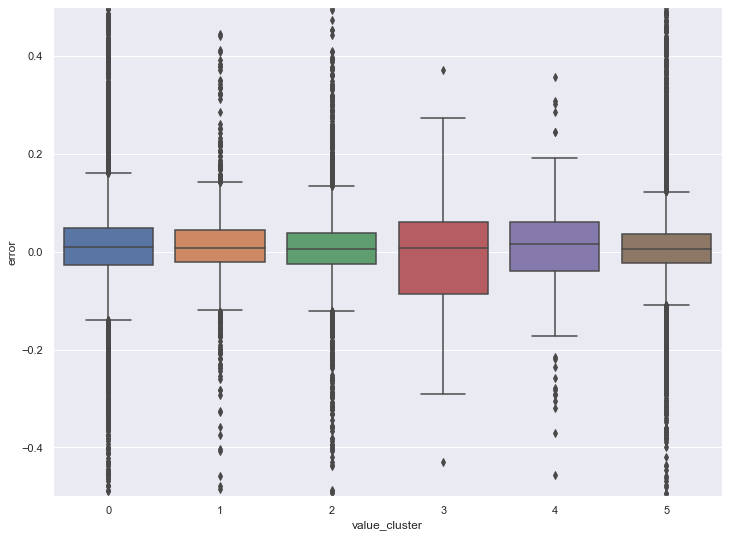

In [57]:
sns.boxplot(X_train.value_cluster, y_train.error)
plt.ylim(-.5,.5)

In [58]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      27955 non-null  int64  
 1   bedroomcnt                    27955 non-null  float64
 2   calculatedfinishedsquarefeet  27955 non-null  float64
 3   fireplacecnt                  27955 non-null  float64
 4   latitude                      27955 non-null  float64
 5   longitude                     27955 non-null  float64
 6   poolcnt                       27955 non-null  float64
 7   regionidcity                  27955 non-null  float64
 8   regionidzip                   27955 non-null  float64
 9   roomcnt                       27955 non-null  float64
 10  transactiondate               27955 non-null  object 
 11  heatingorsystemdesc           27955 non-null  object 
 12  age                           27955 non-null  float64
 1

In [59]:
cluster0 = train[train.value_cluster == 0].error
cluster1 = train[train.value_cluster == 1].error
cluster2 = train[train.value_cluster == 2].error
cluster3 = train[train.value_cluster == 3].error
cluster4 = train[train.value_cluster == 4].error
cluster5 = train[train.value_cluster == 5].error

In [60]:
f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4)
p

4.615914248209213e-07

In [61]:
X_validate_scaled, X_test_scaled = add_to_train(train_clusters, cluster_col_name = 'value_cluster', X_train = X_validate_scaled, X_train_scaled = X_test_scaled)

In [62]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   heatingorsystemdesc                  27955 non-null  object 
 1   county                               27955 non-null  object 
 2   los_angeles                          27955 non-null  uint8  
 3   orange                               27955 non-null  uint8  
 4   ventura                              27955 non-null  uint8  
 5   central_heating                      27955 non-null  uint8  
 6   floor_wall_heating                   27955 non-null  uint8  
 7   no_heating                           27955 non-null  uint8  
 8   bedroomcnt_scaled                    27955 non-null  float64
 9   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 10  fireplacecnt_scaled                  27955 non-null  float64
 11  latitude_scaled         

In [63]:
dummy_df = pd.get_dummies(X_train_scaled,
                           columns=['size_cluster','feature_cluster', 'value_cluster'], 
                           drop_first=True)

In [64]:
X_train_scaled = dummy_df.drop(columns=['fireplacecnt_scaled', 'poolcnt_scaled', 'structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled','calculatedfinishedsquarefeet_scaled', 'acres_scaled'])

In [66]:
dummy_df = pd.get_dummies(X_validate_scaled,
                           columns=['size_cluster','feature_cluster', 'value_cluster'], 
                           drop_first=True)

In [67]:
X_validate_scaled = dummy_df.drop(columns=['fireplacecnt_scaled', 'poolcnt_scaled', 'structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled','calculatedfinishedsquarefeet_scaled', 'acres_scaled'])

In [70]:
dummy_df = pd.get_dummies(X_test_scaled,
                           columns=['size_cluster','feature_cluster', 'value_cluster'], 
                           drop_first=True)

In [71]:
X_test_scaled = dummy_df.drop(columns=['fireplacecnt_scaled', 'poolcnt_scaled', 'structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled','calculatedfinishedsquarefeet_scaled', 'acres_scaled'])

In [74]:
X_train_scaled.to_csv("X_train_scaled.csv")
X_validate_scaled.to_csv("X_validate_scaled.csv")
X_test_scaled.to_csv("X_test_scaled.csv")